# Background Information

##### What is the problem?
The primary business problem that needs to be solved is being able to predict the price of a car, given a set of data points that explain various attributes of a particular car.

While we have been provided with many attributes (along with price) in the dataset, it is upto us to build a solution that ensures that selection of the attributes that have the highest predictive power, while also considering the the rules of each solution we build (1 independent variable, etc.)

##### Who might be interested in this problem, and why?

There are a few personas that would likely be interested in this problem:
- [x] Car manufacturing companies
- [x] Resellers / Retailers
- [x] Car insurance companies
- [x] and others...

The primary use cases of the solution would be to understand the below:
- [x] Understand which are / are not good predictors of price
- [x] Understand (Quantify) by how much price changes for a change in the selected attributes
- [x] Be able to come up with a final price value, when provided with a value of attribute

# An Outline for the Tasks Ahead..

Before we begin solving any business problem that requires modelling of data, it is paramount that we complete the below checklist items (as part of a standard process regardless of the problem statement or/and domain):

- [x] **COMPLETED** Business Requirements Gathering / Problem Identification (Background Information)
- [ ] Pre-requisites setup (Importing packages, etc.)
- [ ] Data source identification and access
- [ ] Exploratory Data Analysis
- [ ] Data Preparation
- [ ] Model Building & Evaluation
- [ ] Model Deployment

While the activities above are not exhaustive, they cover the core requirements of any data modelling exercise.

# Import all Required Packages

**NOTE:** It is important to ensure that all required packages have been installed and upgraded BEFORE running the rest of this code. Without all pre-requisites being fulfilled, the code is likely to run into an error.

Important lines of code to remember (all can be run on Anaconda Prompt):

- pip install "package_name" (to install a package)
- pip install --upgrade "package_name" (to upgrade a package)

In [731]:
# We import all required packages for the purpose of executing this model
# Pandas helps us initialize and use the provided car pricing data in the form of a dataframe
# Sklearn contains a set of linear models available, from which we select logistic regression (for the purpose of this model)
# Sklearn also contains a set of metrics that can be used to evaluate the performance of our model. We chose accuracy score.

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import math

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm

#### Custom Function Declaration

We declare a custom function which will help us to easily calculate model performance metrics. Using this function, we can simply pass the independent variables (from train, test), the predictor variables (from train, test), and the model object itself.

In [732]:
def train_test_metrics(X_train,X_test,y_train,y_test,model):
    names=['R2','Adj-R2','MAE','MAPE','SSE'] 
    
    # Training Metrics
    y_hat = model.predict(X_train)
    
    # Create R2
    r2 = r2_score(y_train,y_hat).round(3)
    
    # Create adj_R2
    adj_r2 = (1-(1-r2_score(y_train,y_hat))*(len(y_train)-1)/(len(y_train)-len(model.coef_)-1)).round(3)

    
    train_metrics = [r2, adj_r2,
                     mean_absolute_error(y_train,y_hat).round(3),
                     mean_absolute_percentage_error(y_train,y_hat).round(3)*100,
                     (mean_squared_error(y_train,y_hat)*len(y_train)).round(3)
                    ]
    train_metrics = pd.DataFrame({'Train':train_metrics},index=names)
    
    # Testing Metrics
    y_hat = model.predict(X_test)
    test_metrics = [r2_score(y_test,y_hat).round(3),
                    (1-(1-r2_score(y_test,y_hat))*(len(y_test)-1)/(len(y_test)-len(model.coef_)-1)).round(3),
                    mean_absolute_error(y_test,y_hat).round(3),
                    mean_absolute_percentage_error(y_test,y_hat).round(3)*100,
                    (mean_squared_error(y_test,y_hat)*len(y_test)).round(3)
                   ]
    test_metrics = pd.DataFrame({'Test':test_metrics},index=names)
    
    all_metrics = train_metrics.merge(test_metrics,left_index=True,right_index=True)
    print(all_metrics)

# Data Source Identification and Access

Here, we connect to the data source that contains the information we need to begin solving this business problem. In this particular case, the data has been provided to us via a CSV file.

<b>Questions</b>

In [733]:
df = pd.read_csv("car_pricing_data.csv") # Reading the data
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

# Exploratory Data Analysis

After storing the data into a dataframe, the first step is to analyze it to understand:

- What does the data represent? 
- What might be the target variable? (If not already specified by the business)
- What steps do we need to take to get the data ready for modeling?
- What are the right features that we need to choose for the purpose of predicting the target variable?

**Steps:**
- [x] Data Exploration
- [x] Data Cleaning
- [x] Data Deep Dive - Numeric (Summary Stats, Outlier Treatment, Feature Transformation, Feature Selection)
- [x] Data Deep Dive - Categorical (Summary Stats, Outlier Treatment, Feature Transformation, Feature Selection)
- [x] Selection of Train & Test Data

><h3>Data Exploration </h3>
First, we load the data and look at a few sample rows (first 5, last 5). We note down any data observations that may require a further deep-dive. Next, we summarize the data to gain more understanding of each column -  we check data types, number of NULLs, and summary statistics (such as mean, median, standard deviation, etc.). We may also try to identify a potential target variable (if not already specified by the business) at this point.

In [734]:
df.tail() #Looking at the last 5 rows of the data, just to get a high level understanding of our data

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920
11913,Lincoln,Zephyr,2006,regular unleaded,221.0,6.0,AUTOMATIC,front wheel drive,4.0,Luxury,Midsize,Sedan,26,17,61,28995


In [735]:
df.dtypes #Used to understand the data types for each column available in our data

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

#### Observations:

- We have 8 categorical variables, and 8 numeric variables.
- MSRP (price) is the obvious target variable
- The meaning of all variables are straightforward and understandable, with the exception of popularity. 

In [736]:
df.describe().T 
#The describe function allows us to calculate summary statistics for all of the columns in our data.
#We use .T to transpose this output, allowing us to view the columns as rows, and the KPIs as columns

,count,mean,std,min,25%,50%,75%,max
year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.00,2017.0
engine_hp,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.00,1001.0
engine_cylinders,11884.0,5.628829,1.780559,0.0,4.0,6.0,6.00,16.0
number_of_doors,11908.0,3.436093,0.881315,2.0,2.0,4.0,4.00,4.0
highway_mpg,11914.0,26.637485,8.863001,12.0,22.0,26.0,30.00,354.0
city_mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.00,137.0
popularity,11914.0,1554.911197,1441.855347,2.0,549.0,1385.0,2009.00,5657.0
msrp,11914.0,40594.737032,60109.103604,2000.0,21000.0,29995.0,42231.25,2065902.0


#### Observations:
- There are 11913 records available in our data.
- MSRP (Price) is the target variable (this has been provided as a requirement)
- There are 8 categorical columns, and 8 numeric columns
- 5 columns have some missing values in them, however "Market Category" has 3,742 missing values - a potential cause for concern
- An interesting observation: The minimum number of engine cylinders comes out to be 0 - which is impossible! (as far as I know) I think it would be interesting to look further into these rows and see if we can invalidate the entire row.

Before moving onto specific data cleaning steps by data type, first I would like to tackle points #4 and #5 above. (Effectively I want to take care of all the missing values first)

><h3>Data Cleaning </h3>
Once we have a general understanding of the data, next we focus on improving the quality. The first step is to look for those columns which have missing values. Once we identify this we can start analyzing each column to see what the appropriate remedial measures are (dropping the row, dropping the column, and/or imputing values with a reasonable subsitute)

In [737]:
# remove any dupes
print('Number of records:', len(df))
df.drop_duplicates()
print('Number of records after dropping dupes:', len(df))

df.isnull().sum() #Used to find out the number of null / missing values in each column of the data

Number of records: 11914
Number of records after dropping dupes: 11914


make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

#### Data Deduplication Observations:

- We attempt to remove duplicates - if any. It seems like the dataset does not have any duplicates.
- Missing values are present in 5 columns - we need to take care of this

#### NEXT STEPS:
- Let's now look at the columns that have missing values in closer detail.
- These columns are - engine_hp, engine_cylinders, engine_fuel_type (only 3), market_category (although this column is being dropped, hence I will skip the analysis of it.

><h3>Data Cleaning - Missing Values </h3>
We deep dive into the columns that have missing values (Market Category, Engine HP, Engine Cylinders, Engine Fuel Type).
The aim is to treat all missing values, either by deleting rows or imputing appropriate values

In [738]:
#First we would like to deep-dive into market category, the column which has the highest number of missing values

df.market_category.nunique()
df.market_category.unique() 

# We shall do a quick check on the % of the data occupied by each value, before making a conclusion on this column.

df.market_category.value_counts() / len(df)
# The top 5 categories represent only ~30% of the total data, which is not enough to make groupings / buckets.

df.market_category.isnull().sum() / len(df)
# Hence, considering the high granularity of these categories, combined with 31.4% of values being missing, I currently am
# proceeding by dropping this column altogether (although this will be revisited)

df = df.drop(columns = 'market_category')

#### Market Category Observations:

- There are 71 unique values of market category, which is a lot

- On further checking the actual market category values, it seems to be a complex combination of keywords such as Performance, Luxury, Hybrid, etc. 

- From the birds-eye view, it seems like a complex exercise to be able to combine multiple of these into a single category, as value is a combination of multiple sub-values, with each sub-value appearing across multiple values. 

In [739]:
df[df.engine_cylinders==0] 

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
539,FIAT,500e,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,108,122,819,31800
540,FIAT,500e,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
541,FIAT,500e,2017,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
1680,Mercedes-Benz,B-Class Electric Drive,2015,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,82,85,617,41450
1681,Mercedes-Benz,B-Class Electric Drive,2016,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,82,85,617,41450
1682,Mercedes-Benz,B-Class Electric Drive,2017,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,82,85,617,39900
4705,Honda,Fit EV,2013,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,105,132,2202,36625
4706,Honda,Fit EV,2014,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,105,132,2202,36625
4785,Ford,Focus,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,99,110,5657,29170
4789,Ford,Focus,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,99,110,5657,29170


#### Engine Cylinders = 0 Observations:

- It seems that engine cylinders are 0 when the car is electric! 
- Now this value makes sense and we can proceed with checking the missing values in Engine Cylinders

In [740]:
df[df.engine_cylinders.isnull()==True]



df = df.drop(df[(df.engine_cylinders.isnull()==True) & (df.engine_fuel_type!='electric')].index)

#For the missing values for engine fuel type = "electric", I will impute the values as 0 since we do know as a fact that electric
#cars do not have cylinders (and we have observed this, too). Let's however ensure that there is no electric car that has a 
#greater than 1 # of cylinders.

df[df.engine_fuel_type=='electric'].engine_cylinders.unique()
#Great! Looks like it's either 0 or missing (nan), hence I think I'm good to impute the value with 0.

array([ 0., nan])

#### Engine Cylinders Missing Values Observations:

- It looks like the engine cylinder missing values actually have some kind of "meaning" behind them.


- On doing some research online, it seems that the Mazda RX-7 and RX-8 have a "rotary" engine, which technically means that it has 0 cylinders. HOWEVER, when we look at a column such as engine_fuel_type, there are definitely entries where the fuel type is "regular unleaded" or "premium unleaded" (what the Mazda RX has), but the engine cylinders do have a greater than 0 value. 


- Hence, I believe that the best course of action is to remove these rows (where engine cylinder is NULL AND engine fuel type IS NOT electric), as: it does not represent the rest of the data correctly + it only affects one make of care (RX series of Mazda).

In [741]:
df[df.engine_hp.isnull()==True]

df = df.drop(df[df.engine_hp.isnull()==True].index)

#### Engine HP Missing Values Observations:

- I cannot find a good reason to justify the missing values for engine_hp, hence I think it is safe to assume that this is a data entry issue. HOWEVER, I will be interested (and will revisit this) to know if this issue is for specific make / model / year of cars.


- DECISION - drop rows that have engine_hp as NULL. it affects a very small percentage of the data and there is no reasonable form of correction that we can do (which may not be worth the effort considering the extent of the issue).

In [742]:
df[df.engine_fuel_type.isnull() == True]
# Looking at the rows that have missing values for fuel type

df[df.model=="Verona"]
# The problematic model is the Suzuki Verona 2004! We do have the Verona from other years, and can do some research online to find out the 2004 model specs

df["engine_fuel_type"].fillna("regular unleaded", inplace=True)
# Based on the observations below, I think it is reasonable to impute this set of missing values with "regular unleaded".

df.loc[df.engine_fuel_type=='electric', 'engine_cylinders'] = 0
#Just ensuring that all the electric cars have cylinder value as 0 (this makes business sense + it's validated with all of the other entries of electric cars)

#### Engine Fuel Type Missing Values Observations:

- We see that the only make, model, year combination that does not have an engine_fuel_type mentioned is the Suzuki Verona 2004. 


- I can also observe that we do have an entry for Suzuki Verona 2005, where the fuel type is mentioned as "regular unleaded". Furthermore, a quick research on this specific model does indicate that it is indeed a "regular unleaded" fuel type car. 


- Since we know that electric cars don't have cylinders + every electric row in our data has cylinder as 0 or nan, we impute 0 for all electric fuel type cars (as a safety measure, to ensure consistency)

In [743]:
#Last we go to number of doors. Let's check the rows

df[df.number_of_doors.isnull()==True]

#Only one row. Research on the Ferrari FF 2013 shows that it is a 2 door car. Will impute this value.

df.loc[df.number_of_doors.isnull()==True, 'number_of_doors'] = 2

#I think now we are done with missing values! Just double checking that we have covered them all:

df.isnull().sum()

#Looks like we are good to go. We no longer have any missing values. 

make                 0
model                0
year                 0
engine_fuel_type     0
engine_hp            0
engine_cylinders     0
transmission_type    0
driven_wheels        0
number_of_doors      0
vehicle_size         0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

#### Number of Doors Missing Values Observations:

- Only the Ferrari FF 2013 has a missing value for number of doors. This can be easily fixed by checking online for the number of doors for this car (it's 2)


#### NEXT STEPS:

- We can begin to analyze numeric and categorical values, and look for outliers, mis-classified data types (using distributions, summary statistics, etc.).


- Once these are identified and treated, we can next begin to look for relationships among variables, and plot a correlation matrix to establish the candidate independent variables.

><h3>Data Deep Dive - Numeric</h3>
Here, we first convert mis-classified data into numeric to ensure that all numeric columns have been correctly identified as numeric by pandas. Next, we check the summary statistics of data for any indications of outliers. We additionally plot a histogram, boxplot, and scatterplot as well to confirm the findings and identify any relationships between the target and any of the independent variables. Once the columns with outliers are established, we deep dive into them to understand the number of outlier rows, and the appropriate treatment method. Once this is complete and our numeric data is ready, we create a correlation matrix to identify correlated features and redundant features.

In [744]:
df.dtypes

df.engine_cylinders.unique() # int values
df.number_of_doors.unique() # int values

#it seems that all variables have been classified into their correct data types. Some minor corrections can be made, including:
#converting engine cylinders, number of doors to int

df['number_of_doors'] = df['number_of_doors'].astype(int)

df['engine_cylinders'] = df['engine_cylinders'].astype(int)

#### Observations:

- All numeric columns are assigned to the correct data type.

- Based on the nature of the columns, I decided to convert number of doors and number of cylinders to integer (as these cannot be decimal values)

In [745]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_temp = df.select_dtypes(include=numerics)

pd.DataFrame(dict(mean = df_temp.mean().round(2),
                  median = df_temp.median().round(2),
                  std_dev = df_temp.std().round(2),
                  min_val = df_temp.min().round(2),
                  max_val = df_temp.max().round(2),
                  missing_vals = df_temp.isnull().sum()
                  
                 ))

,mean,median,std_dev,min_val,max_val,missing_vals
year,2010.36,2015.0,7.59,1990.0,2017.0,0
engine_hp,249.42,227.0,109.28,55.0,1001.0,0
engine_cylinders,5.65,6.0,1.76,0.0,16.0,0
number_of_doors,3.43,4.0,0.88,2.0,4.0,0
highway_mpg,26.38,26.0,7.73,12.0,354.0,0
city_mpg,19.40,18.0,7.11,7.0,137.0,0
popularity,1553.10,1385.0,1439.56,2.0,5657.0,0
msrp,40570.96,29970.0,60298.09,2000.0,2065902.0,0


#### High Level Outlier Detection Observations:

- We observe that the standard deviation is quite high for the msrp column. It's mean is also quite far from the median. We would need to deep dive into this further to understand the details of the discrepancy


- Apart from the MSRP column it is actually very unlikely that there are outliers in any other column (at least based on the standard deviation + mean vs. median comparison)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

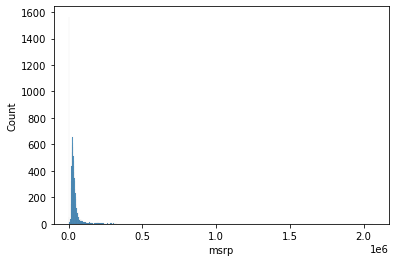

In [746]:
sns.histplot(df_temp['msrp'])

#### MSRP Observations:

- There seems to be a large tail of values for the msrp column. We may have to investigate further to better understand the range of values and what we (may) need to do with them

In [747]:
df.sort_values(by='msrp',ascending=False).head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
11362,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,820,2065902
11364,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001.0,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,820,1705769
8486,Lamborghini,Reventon,2008,premium unleaded (required),650.0,12,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,9,1158,1500000
11363,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,820,1500000
6351,Maybach,Landaulet,2012,premium unleaded (required),620.0,12,AUTOMATIC,rear wheel drive,4,Large,Convertible,16,10,67,1382750


#### MSRP Observations:

- It seems that the price values make sense. There are some cars which are super premium, and hence have a very high price.


- However, these premium cars are not "general" - meaning that they would not be sold in most dealerships, and a majority of customers would not look for / purchase these cars

In [748]:
df[df.msrp>110000].count()

make                 576
model                576
year                 576
engine_fuel_type     576
engine_hp            576
engine_cylinders     576
transmission_type    576
driven_wheels        576
number_of_doors      576
vehicle_size         576
vehicle_style        576
highway_mpg          576
city_mpg             576
popularity           576
msrp                 576
dtype: int64

#### MSRP Observations:

- Taking 110000 dollars as a cutoff, we can see that there are only 576 values that are above this cutoff. I think this is a good place to start to remove outliers (in the MSRP column)


- There are only 576 rows which have a price greater than 110000. That's well below the max prices that we saw earlier


- Hence, for now I am dropping all rows that have msrp > 110000. This will still leave us with 95% of the data.

In [749]:
df = df.drop(df[df.msrp>110000].index)

df_temp = df.select_dtypes(include=numerics)

pd.DataFrame(dict(mean = df_temp.mean().round(2),
                  median = df_temp.median().round(2),
                  std_dev = df_temp.std().round(2),
                  min_val = df_temp.min().round(2),
                  max_val = df_temp.max().round(2),
                  missing_vals = df_temp.isnull().sum()
                  ))

,mean,median,std_dev,min_val,max_val,missing_vals
year,2010.24,2015.0,7.71,1990.0,2017.0,0
engine_hp,235.25,219.0,89.84,55.0,707.0,0
engine_cylinders,5.45,6.0,1.48,0.0,12.0,0
number_of_doors,3.48,4.0,0.86,2.0,4.0,0
highway_mpg,26.73,26.0,7.72,12.0,354.0,0
city_mpg,19.74,18.0,7.10,10.0,137.0,0
popularity,1570.91,1385.0,1449.89,21.0,5657.0,0
msrp,30785.88,29100.0,19319.83,2000.0,109990.0,0


#### MSRP Observations:

- The outlier rows have been dropped, however there still seems to be somewhat of an opportunity to improve the state of the MSRP column

<AxesSubplot:xlabel='msrp', ylabel='Count'>

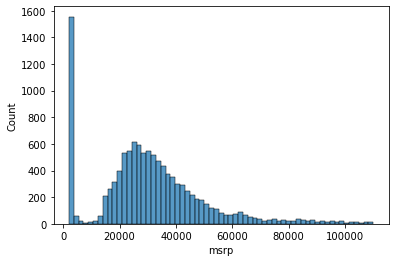

In [750]:
sns.histplot(df['msrp'])

#It seems that we have a lot of values on the lower end of the plot - seems to be values around the 2000 mark. Let's investigate this further

#### MSRP Observations:

- It seems that we have a lot of values on the lower end of the plot - seems to be values around the 2000 mark. Let's investigate this further

In [751]:
df['msrp'].value_counts()

2000     1036
29995      19
25995      19
27995      16
20995      16
         ... 
35360       1
37665       1
39610       1
51585       1
50920       1
Name: msrp, Length: 5555, dtype: int64

#### MSRP Observations:

- A lot of data points have msrp as 2000. This seems strange, as it looks like some kind of default value when the price is actually "unknown".

In [752]:
df[df.msrp==2000].year.unique()

df = df.drop(df[df.msrp==2000].index)

#### MSRP Observations:

- Interestingly, it seems that all of these data points are from the year 2000 and below. Might need to reach out to the business to understand what this might indicate.


- For now, these rows will need to be dropped.

In [753]:
# We now recheck the summary statistics to understand if the problem has been resolved.

df_temp = df.select_dtypes(include=numerics)

pd.DataFrame(dict(mean = df_temp.mean().round(2),
                  median = df_temp.median().round(2),
                  std_dev = df_temp.std().round(2),
                  min_val = df_temp.min().round(2),
                  max_val = df_temp.max().round(2),
                  missing_vals = df_temp.isnull().sum()
                  
                 ))

,mean,median,std_dev,min_val,max_val,missing_vals
year,2011.95,2015.0,5.77,1990.0,2017.0,0
engine_hp,244.43,236.0,88.21,66.0,707.0,0
engine_cylinders,5.47,6.0,1.49,0.0,12.0,0
number_of_doors,3.53,4.0,0.83,2.0,4.0,0
highway_mpg,26.94,26.0,7.88,13.0,354.0,0
city_mpg,19.90,19.0,7.31,10.0,137.0,0
popularity,1584.74,1385.0,1445.92,21.0,5657.0,0
msrp,33705.90,30665.0,17847.45,2002.0,109990.0,0


<AxesSubplot:xlabel='msrp', ylabel='Count'>

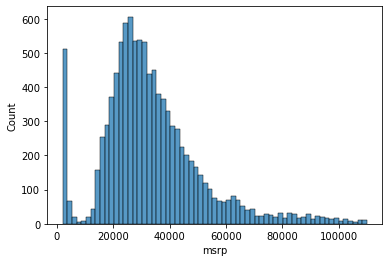

In [754]:
sns.histplot(df['msrp'])

This graph illustrates the outlier / unusual values present in the lower side of MSRP. We need to correct this in order to achieve optimal model performance

#### MSRP Observations:

- We observe that there are some outlier / unusual values towards the lower (left) portion of the plot. This requires treatment before we can push it into our model.

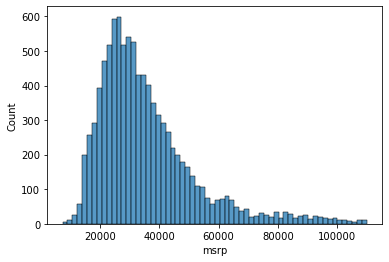

In [755]:
sns.histplot(df[(df.msrp>=7000)].msrp)

df = df[(df.msrp>=7000)]

The above graph illustrates the skewed distribution of MSRP. This indicates that we may need to log transform the variable in order to obtain a normal distribution.

#### Observations:

- We remove the outlier data points, and we now have a skewed distribution for MSRP. (We may need to log transform)

#### NEXT STEPS:
- The rest of the columns seem good. Let's now deep-dive into the correlation matrix of all the numeric variables.

><h3>Correlation Matrix</h3>
Now that our (numeric) data is ready, we can start to generate and look at the correlation matrix. From this we can understand which are those independent variables that seem to influence MSRP the most.

In [756]:
df.select_dtypes(include=numerics).corr()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp
year,1.000000,0.227779,-0.126562,0.129011,0.274274,0.227624,0.145343,0.272197
engine_hp,0.227779,1.000000,0.771219,-0.064443,-0.451223,-0.469709,0.093482,0.795322
engine_cylinders,-0.126562,0.771219,1.000000,-0.024535,-0.637795,-0.625921,0.084079,0.544744
number_of_doors,0.129011,-0.064443,-0.024535,1.000000,0.022668,0.057540,-0.051853,-0.045816
highway_mpg,0.274274,-0.451223,-0.637795,0.022668,1.000000,0.841032,-0.031758,-0.250491
city_mpg,0.227624,-0.469709,-0.625921,0.057540,0.841032,1.000000,-0.018011,-0.265999
popularity,0.145343,0.093482,0.084079,-0.051853,-0.031758,-0.018011,1.000000,0.037832
msrp,0.272197,0.795322,0.544744,-0.045816,-0.250491,-0.265999,0.037832,1.000000


#### Observations:

- Engine horsepower seems to have the highest (positive) correlation (75.7%) with MSRP
- It seems that engine horsepower might be the best variable to move forward with, as the other variables don't show a high enough correlation
- Apart from this, we see that engine hp is strongly correlated with engine cylinders as well (74.04%)

<AxesSubplot:xlabel='engine_hp', ylabel='Count'>

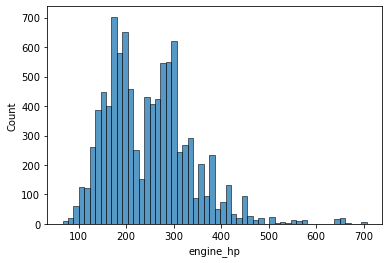

In [757]:
sns.histplot(df['engine_hp'])

The above graph illustrates the bimodal skewed distribution of Engine HP. This shows us that we will need to apply corrective steps to get a normal distribution (and potentially to resolve the bimodal distribution)

#### Observations:

- Engine HP has the highest correlation with MSRP! However, interestingly the distribution seems to be a bi-modal distribution! I need to research more to see if I need to apply any special treatment here.

- One thing that comes to mind is possibly "splitting" this variable into 2 sets, so that each set has a normal distribution of it's own

- However I am skipping this for now. Also note that the distribution is currently skewed (and hence may require log transform)


<AxesSubplot:xlabel='city_mpg', ylabel='msrp'>

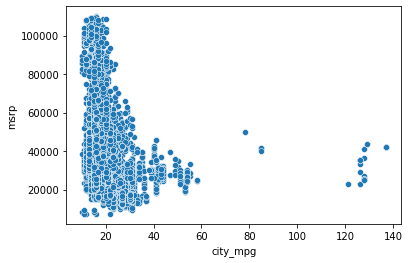

In [758]:
#just checking the plots of the variables with low correlation, to confirm that they indeed have no relationship
sns.scatterplot(x='city_mpg',y='msrp',data=df)

#### Observations:

- For highway and city mpg, it can be observed that there is no discernable pattern for majority of the data (although, for higher mpg values (which are rare), there is a slight indication of a negative msrp trend)

- This negative trend also does not make business sense, as cars that are more efficient would typically sell for a higher price

<AxesSubplot:xlabel='popularity', ylabel='msrp'>

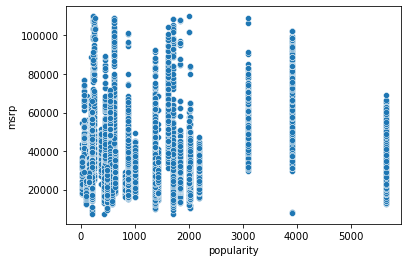

In [759]:
sns.scatterplot(x='popularity',y='msrp',data=df)

#### Observations:

- For both number of doors and popularity, there is no discernable pattern.
- There are high MSRP values across popularity / number of doors values.
- Also, number of doors has very few observations, and can almost be considered as a categorical variable.

In [760]:
# Based on the correlation observations above, we can drop the below columns:

df = df.drop(columns = ['year', 'engine_cylinders', 'number_of_doors', 'popularity','highway_mpg','city_mpg'])

#### Observations:

- Year - while the correlation is higher than other variables, it is still lower than engine hp. Hence dropping it for now.
- Engine cylinders - as it has a low correlation with msrp + it is highly correlated with engine hp
- Number of doors - almost no (0) correlation
- Popularity - as it is currently unexplainable + has a low correlation
- Highway mpg, city mpg - it does not have a significant correlation (~17%)

><h3>Data Deep Dive - Categorical</h3>
For categorical variables, the first thing we want to understand is - what are the unique values for each categorical column? This will help to explain each column to understand it's effect on the target variable. Once this is complete, we can begin to summarize the target variable as a function of each unique value in the categorical column/s. If we observe that there is not much variance in the target variable (mean) between unique values of the categorical column, we may then choose to drop the column as it is not beneficial. We then convert the categorical variables to numerical indicators through a process known as "one-hot encoding". We ensure to drop those columns that are not beneficial in predicting / influencing the target variable value.

In [761]:
# We now focus solely on the categorical columns.
categorical = ['object']

df_temp = pd.merge(df['msrp'],df.select_dtypes(include=categorical),left_index=True,right_index=True)

df_temp.head()
# To verify that we have all the categorical variables that we expect

,msrp,make,model,engine_fuel_type,transmission_type,driven_wheels,vehicle_size,vehicle_style
0,46135,BMW,1 Series M,premium unleaded (required),MANUAL,rear wheel drive,Compact,Coupe
1,40650,BMW,1 Series,premium unleaded (required),MANUAL,rear wheel drive,Compact,Convertible
2,36350,BMW,1 Series,premium unleaded (required),MANUAL,rear wheel drive,Compact,Coupe
3,29450,BMW,1 Series,premium unleaded (required),MANUAL,rear wheel drive,Compact,Coupe
4,34500,BMW,1 Series,premium unleaded (required),MANUAL,rear wheel drive,Compact,Convertible


#### Observations:

- One would expect that make (brand) would be a definite independent variable, however my question is - if new brands come in (and they do), how would the model treat this data? Would the make column have any effect then?


- I believe that larger vehicle sizes should cost more (this is a hypothesis which will be tested)


- Engine fuel type that is premium may cost more (however let's see what unique values are present, and which are the most frequently appearing ones)

In [762]:
df_temp['make'].unique()

df_temp['model'].unique()

# Make and Model have a lot of unique values. It will be a challenge to be able to group up these values together into buckets,
# however will check if any specific values contribute to a significant percentage of the total data

df.make.value_counts() / len(df)

df.model.value_counts() / len(df)

# On checking the top 5-10 values (based on % of total data), we cannot conclude that segmenting the rest of the values into "other" will be useful.
# This is because the top 5-10 contributes roughly 5% - 20% of the total data, which is not the majority.
# I am going to drop the columns which had too many unique values (make, model)

df = df.drop(columns = ['make','model'])

#sns.catplot(x="make", y="msrp", data=df, height=7,aspect=1.5)

#We drop these columns as they are currently not useful for our model

df_temp = pd.merge(df['msrp'],df.select_dtypes(include=categorical),left_index=True,right_index=True)

#### Make / Model Observations:

- NOTE - Although "make" seems like a good choice for an independent variable, I have not used it for the following reasons:
    - 1- It is not geared towards new makes (brands). If a new make were to be available, the model may not be able to predict correctly.
    - 2- There are many unique values which are difficult to combine into buckets

In [763]:
df_temp['engine_fuel_type'].unique()

df.engine_fuel_type.value_counts() / len(df)

#For engine fuel type, the top 4 values represent ~97% of our data. Hence we can consider these values and group everything else into "Other"

fuel_other_list = ['diesel', 'flex-fuel (premium unleaded recommended/E85)', 'electric', 'flex-fuel (premium unleaded required/E85)', 'natural gas']

#This is the list of fuel types that we will group into "Other". 

df['engine_fuel_type'] = df['engine_fuel_type'].replace(fuel_other_list, 'Other')

df['engine_fuel_type'].unique()

array(['premium unleaded (required)', 'premium unleaded (recommended)',
       'flex-fuel (unleaded/E85)', 'regular unleaded', 'Other'],
      dtype=object)

#### Engine Fuel Type Observations:

- We can take the top 4 (based on # of observations) as they contribute to majority of the data, while the rest can be grouped as "Other"

In [764]:
df_temp['driven_wheels'].unique()

df_temp['vehicle_size'].unique()

df_temp['vehicle_style'].unique()

df.vehicle_style.value_counts() / len(df)

#Driven wheels and vehicle size don't have many unique values, which is good.
#However, vehicle style does have quite a few values, and there is no discernable grouping that can be done (the data is somewhat varied)
#I want to group up data only if ~90% of the data is represented by ~5-6 unique values in a categorical column
#I thought about grouping up values based on common text - for e.g. Van, Minivan, SUV, etc. Let's try that below:

df['vehicle_style'] = df['vehicle_style'].replace(['2dr Hatchback', '4dr Hatchback'], 'Hatchback')
df['vehicle_style'] = df['vehicle_style'].replace(['2dr SUV', '4dr SUV'], 'SUV')
df['vehicle_style'] = df['vehicle_style'].replace(['Cargo Minivan', 'Passenger Minivan'], 'Minivan')
df['vehicle_style'] = df['vehicle_style'].replace(['Cargo Van', 'Passenger Van'], 'Van')
df['vehicle_style'] = df['vehicle_style'].replace(['Crew Cab Pickup', 'Extended Cab Pickup', 'Regular Cab Pickup'], 'Pickup')

#Based on the variance of msrp for each of the subsequent (new) unique values, will make a decision on whether to keep or drop the variable

#We now take a look at the tranmission type column:

df_temp['transmission_type'].unique()

df_temp.transmission_type.value_counts() / len(df)

#We can see that automatic and manual together contribute ~95% of our data. At first glace I may have grouped up everything except these 2 into "Other"
#However, I am interested to see the average msrp's for all the unique values of categorical columns (before we drop any)

AUTOMATIC           0.762142
MANUAL              0.188144
AUTOMATED_MANUAL    0.047010
DIRECT_DRIVE        0.002496
UNKNOWN             0.000208
Name: transmission_type, dtype: float64

#### Vehicle Style Observations:

- We can group vehicle style based on "Car Type" - SUV, Hatchback, etc.

- We will need to check the average values of MSRP for each of the categorical variables to take a final call on what to include in the model

In [765]:
df_temp = pd.merge(df['msrp'],df.select_dtypes(include=categorical),left_index=True,right_index=True)

global_mean = df_temp['msrp'].mean()

for col in df_temp.columns[1:]:
    df_group = df_temp.groupby(by=col).msrp.agg(['mean']).round(2)
    df_group['diff'] = (df_group['mean'] - global_mean).round(2)
    display(df_group)
    
# We can see clear differences across all of the categorical variables that we have.
# I think there is a merit to keep AUTOMATED_MANUAL as a separate value, as it does show a difference in msrp vs. others (so manual, automatic, automated manual will be separate while everything else goes into "Others")

df['transmission_type'] = df['transmission_type'].replace(['DIRECT_DRIVE', 'UNKNOWN'], 'Other')

df_temp = pd.merge(df['msrp'],df.select_dtypes(include=categorical),left_index=True,right_index=True)

global_mean = df_temp['msrp'].mean()

for col in df_temp.columns[1:]:
    df_group = df_temp.groupby(by=col).msrp.agg(['mean']).round(2)
    df_group['diff'] = (df_group['mean'] - global_mean).round(2)
    display(df_group)

,mean,diff
engine_fuel_type,,
Other,46806.99,11185.25
flex-fuel (unleaded/E85),37060.46,1438.72
premium unleaded (recommended),40258.99,4637.25
premium unleaded (required),53629.26,18007.52
regular unleaded,28974.51,-6647.23


,mean,diff
transmission_type,,
AUTOMATED_MANUAL,39075.03,3453.29
AUTOMATIC,36829.54,1207.80
DIRECT_DRIVE,33795.83,-1825.91
MANUAL,29919.82,-5701.92
UNKNOWN,9057.50,-26564.24


,mean,diff
driven_wheels,,
all wheel drive,43078.09,7456.35
four wheel drive,40696.99,5075.25
front wheel drive,26511.23,-9110.51
rear wheel drive,42261.04,6639.30


,mean,diff
vehicle_size,,
Compact,28748.87,-6872.87
Large,45543.35,9921.61
Midsize,36610.56,988.82


,mean,diff
vehicle_style,,
Convertible,45390.81,9769.07
Convertible SUV,26850.00,-8771.74
Coupe,43011.52,7389.78
Hatchback,23397.48,-12224.26
Minivan,29321.77,-6299.97
Pickup,32796.26,-2825.48
SUV,40015.74,4394.00
Sedan,35771.95,150.21
Van,33020.36,-2601.38


,mean,diff
engine_fuel_type,,
Other,46806.99,11185.25
flex-fuel (unleaded/E85),37060.46,1438.72
premium unleaded (recommended),40258.99,4637.25
premium unleaded (required),53629.26,18007.52
regular unleaded,28974.51,-6647.23


,mean,diff
transmission_type,,
AUTOMATED_MANUAL,39075.03,3453.29
AUTOMATIC,36829.54,1207.80
MANUAL,29919.82,-5701.92
Other,31892.88,-3728.86


,mean,diff
driven_wheels,,
all wheel drive,43078.09,7456.35
four wheel drive,40696.99,5075.25
front wheel drive,26511.23,-9110.51
rear wheel drive,42261.04,6639.30


,mean,diff
vehicle_size,,
Compact,28748.87,-6872.87
Large,45543.35,9921.61
Midsize,36610.56,988.82


,mean,diff
vehicle_style,,
Convertible,45390.81,9769.07
Convertible SUV,26850.00,-8771.74
Coupe,43011.52,7389.78
Hatchback,23397.48,-12224.26
Minivan,29321.77,-6299.97
Pickup,32796.26,-2825.48
SUV,40015.74,4394.00
Sedan,35771.95,150.21
Van,33020.36,-2601.38


#### Categorical Variables - MSRP Avg. Observations:

- I am a bit worried about vehicle style for multiple reasons:
    1 - What if a new vehicle style comes in / the data entry process is random? I would like the model to be generalizable
    2 - I'm not too sure how we would explain this variable to the business, most businesses would like to have different types of cars
    
    
- The rest of the variables look good (in terms of the variance in avg. MSRP)

In [766]:
#I am dropping the vehicle style column as it looks like there is not much variance between each unique value to warrant inclusion in the model
#Apart from that, it still has quite a few unique values, hence I feel there may be better categorical columns to use

df = df.drop(columns = ['vehicle_style'])

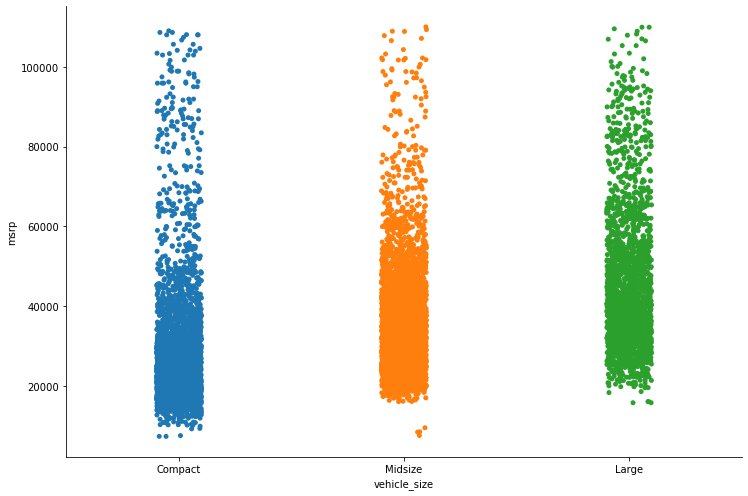

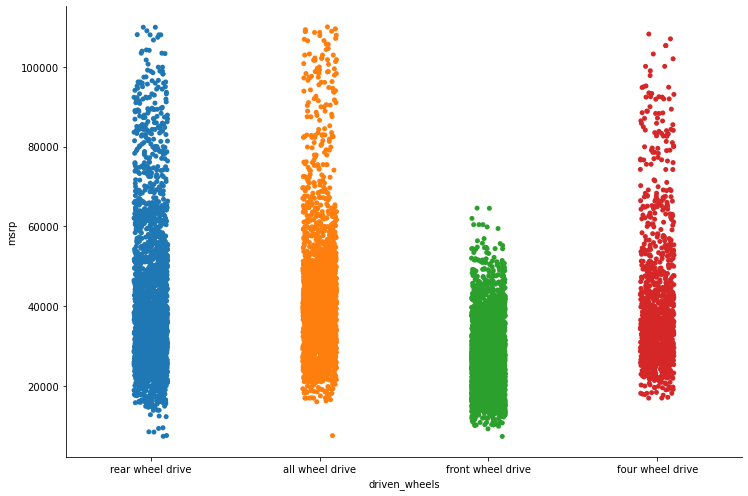

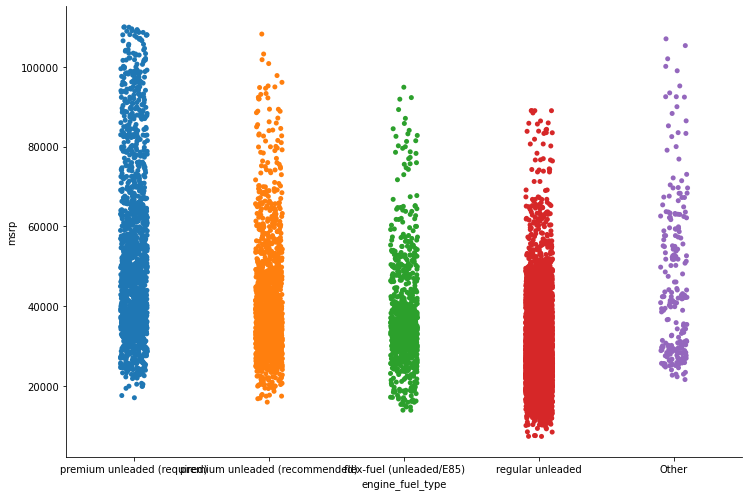

In [767]:
sns.catplot(x="vehicle_size", y="msrp", data=df, height=7,aspect=1.5)
sns.catplot(x="driven_wheels", y="msrp", data=df, height=7,aspect=1.5)
sns.catplot(x="engine_fuel_type", y="msrp", data=df, height=7,aspect=1.5)
#sns.catplot(x="transmission_type", y="msrp", data=df, height=7,aspect=1.5)

The above graphs display the value of avg. MSRP for each of the unique values within engine fuel type, vehicle size, and driven wheels. Note that all graphs show some kind of variance between each unique value within the categorical variable

#### Observations:

- On plotting a categorical plot for the selected categorical variables, 3 plots are of particular interest
    - Vehicle size, Engine Fuel Type, and Driven Wheels all show a significant difference in msrp values across the various unique values.
    
    
- Between all of them, I would say that the priority order would be:
    - Engine Fuel Type > Vehicle Size > Driven Wheels
    
    
- Hence, I believe in terms of categorical variables, these 3 are be the best ones.

In [768]:
df = df.drop(columns=['transmission_type'])

df.tail()

,engine_fuel_type,engine_hp,driven_wheels,vehicle_size,msrp
11909,premium unleaded (required),300.0,all wheel drive,Midsize,46120
11910,premium unleaded (required),300.0,all wheel drive,Midsize,56670
11911,premium unleaded (required),300.0,all wheel drive,Midsize,50620
11912,premium unleaded (recommended),300.0,all wheel drive,Midsize,50920
11913,regular unleaded,221.0,front wheel drive,Midsize,28995


#### Observations:

- Here is our final dataset. We have the following (potential) independent variables:
- Engine Fuel Type, Engine HP, Driven Wheels, Vehicle Size
- Our target variable is: MSRP

- The data being used for model building will be derived from this "df" dataset that we have prepared.

>**Finally - let's convert categorical vars to numerical indicators**

# Data Preparation

Now that we have completed the Exploratory Data Analysis and have prepared the columns in the data to be ready for modeling - we can now begin to set up the features and target variable for inclusion in the model function.

In [769]:
cat_vars = ['engine_fuel_type','driven_wheels','vehicle_size']

for var in cat_vars:
    df[var] = df[var].astype("category")

df = pd.get_dummies(df,columns=cat_vars, prefix_sep='_')

In [770]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9615 entries, 0 to 11913
Data columns (total 14 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   engine_hp                                        9615 non-null   float64
 1   msrp                                             9615 non-null   int64  
 2   engine_fuel_type_Other                           9615 non-null   uint8  
 3   engine_fuel_type_flex-fuel (unleaded/E85)        9615 non-null   uint8  
 4   engine_fuel_type_premium unleaded (recommended)  9615 non-null   uint8  
 5   engine_fuel_type_premium unleaded (required)     9615 non-null   uint8  
 6   engine_fuel_type_regular unleaded                9615 non-null   uint8  
 7   driven_wheels_all wheel drive                    9615 non-null   uint8  
 8   driven_wheels_four wheel drive                   9615 non-null   uint8  
 9   driven_wheels_front wheel dri

#### Observations:

- We now have the categorical variables ready for use, however we will drop 1 from each as the values of the remaining would determine the entire categorical variable

In [771]:
df = df.drop(['engine_fuel_type_Other','driven_wheels_all wheel drive','vehicle_size_Compact'], axis=1)

df.columns = ['engine_hp', 'msrp', 'engine_fuel_type_flex_fuel', 'engine_fuel_type_prem_unlead_recom', 
              'engine_fuel_type_prem_unlead_req', 'engine_fuel_type_reg_unlead', 'driven_wheels_four_wheel',
             'driven_wheels_front_wheel','driven_wheels_rear_wheel','vehicle_size_large','vehicle_size_midsize']

df.info()


# Have dropped the columns accordingly, and below is the final set of variables we will use.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9615 entries, 0 to 11913
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   engine_hp                           9615 non-null   float64
 1   msrp                                9615 non-null   int64  
 2   engine_fuel_type_flex_fuel          9615 non-null   uint8  
 3   engine_fuel_type_prem_unlead_recom  9615 non-null   uint8  
 4   engine_fuel_type_prem_unlead_req    9615 non-null   uint8  
 5   engine_fuel_type_reg_unlead         9615 non-null   uint8  
 6   driven_wheels_four_wheel            9615 non-null   uint8  
 7   driven_wheels_front_wheel           9615 non-null   uint8  
 8   driven_wheels_rear_wheel            9615 non-null   uint8  
 9   vehicle_size_large                  9615 non-null   uint8  
 10  vehicle_size_midsize                9615 non-null   uint8  
dtypes: float64(1), int64(1), uint8(9)
memory u

><h3>Feature Transformations - Log Transform</h3>
We apply a log transform for the 2 columns we identified earlier - MSRP and Engine HP.

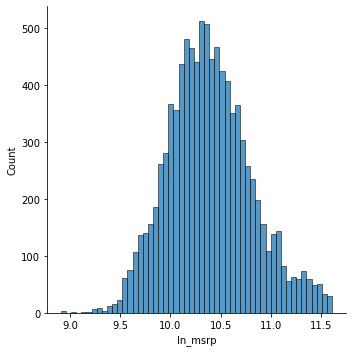

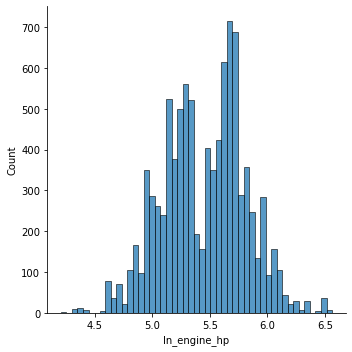

In [772]:
df['ln_msrp'] = np.log1p(df['msrp'])
df['ln_engine_hp'] = np.log1p(df['engine_hp'])

#We first log transform MSRP and Engine HP, which have skewed distributions. This will ensure the distribution is normal (as required by linear regression)

sns.displot(df.ln_msrp)
sns.displot(df.ln_engine_hp)

The above graphs display the log transformed values of MSRP and Engine HP. Note that the distributions now appear normal, and hence these transformed variables can be used in our linear regression model.

><h3>Selection of Train & Test data</h3>
Now that we have completed all of the aforementioned steps, we can create the testing and training dataset by choosing a random sample of 70% of the data for training purposes, while the remaining 30% is used for testing the model output to determine accuracy.

In [773]:
predictors = ['ln_engine_hp','engine_fuel_type_flex_fuel', 'engine_fuel_type_prem_unlead_recom', 
             'engine_fuel_type_prem_unlead_req', 'engine_fuel_type_reg_unlead', 'driven_wheels_four_wheel',
             'driven_wheels_front_wheel', 'driven_wheels_rear_wheel', 'vehicle_size_large', 'vehicle_size_midsize']

# We have split the predictors and target variable (above and below are just lists that contain their names)

target = ['ln_msrp']

X = df[predictors]
y = df[target]

# We have X, which is our set of independent variables. Y is our target variable

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=2)

# Model Building & Evaluation

Now that our split (train / test) data is ready, we can start to build our linear regression models

><h3>Running the Model (First - Simple - One Independent Variable)  </h3>
Train and test a simple regression model.  SIMPLE means that your model with include only ONE explanatory variable.  Choose the feature you believe is the best one for this model.

In [774]:
simple_var = ['ln_engine_hp']

model = LinearRegression()
model.fit(X_train[simple_var],y_train)

# Display Output
train_test_metrics(X_train[simple_var],X_test[simple_var],y_train,y_test,model)

print('1% Engine HP increase effect on MSRP:', round(model.coef_[0][0],2), "% change")
# A 1% increase in Engine HP will lead to a 0.97% increase in the MSRP

          Train     Test
R2        0.683    0.679
Adj-R2    0.683    0.679
MAE       0.182    0.183
MAPE      1.700    1.800
SSE     372.674  163.622
1% Engine HP increase effect on MSRP: 0.97 % change


#### Model 1 Observations:

- Training Data MAPE = 1.7%
- Testing Data MAPE = 1.8%
- There is no evidence of overfitting as the MAPE values for train and test are very close to each other.
- Model interpretation
    - A 1% increase in Engine HP will result in an estimated 0.97% change in MSRP.

><h3>Running the Model (Second - 1 Continuous & 1 Categorical)  </h3>
Train and test a second regression model – this model should include ONE continuous numerical feature and ONE categorical variable (note: you may have multiple indicator variables representing a single categorical variable).  You can include the indicator variables as either intercept shifters, slope-shifters, or both (you decide).

In [775]:
#Tried running the model considering 3 scenarios:
# Scenario 1 - Running with Engine HP and the Engine Fuel Type values (as is, engine fuel type = intercept shifter)
# Scenario 2 - Running with Engine HP and Engine Fuel Type (engine fuel type = slope shifter)
# Scenario 3 - Running with Engine HP and Engine Fuel Type (Engine fuel type = intercept AND slope shifter)
# Out of these 3 scenarios, Scenario 3 (intercept + slope shifter) had a slightly higher R2 and slightly lower MAE. Hence, this was chosen.

X_train = X_train.assign(flex_fuel_X_enginehp = X_train['ln_engine_hp'] * X_train['engine_fuel_type_flex_fuel'])
X_train = X_train.assign(prem_unlead_recom_X_enginehp = X_train['ln_engine_hp'] * X_train['engine_fuel_type_prem_unlead_recom'])
X_train = X_train.assign(prem_unlead_req_X_enginehp = X_train['ln_engine_hp'] * X_train['engine_fuel_type_prem_unlead_req'])
X_train = X_train.assign(reg_unlead_X_enginehp = X_train['ln_engine_hp'] * X_train['engine_fuel_type_reg_unlead'])

X_test = X_test.assign(flex_fuel_X_enginehp = X_test['ln_engine_hp'] * X_test['engine_fuel_type_flex_fuel'])
X_test = X_test.assign(prem_unlead_recom_X_enginehp = X_test['ln_engine_hp'] * X_test['engine_fuel_type_prem_unlead_recom'])
X_test = X_test.assign(prem_unlead_req_X_enginehp = X_test['ln_engine_hp'] * X_test['engine_fuel_type_prem_unlead_req'])
X_test = X_test.assign(reg_unlead_X_enginehp = X_test['ln_engine_hp'] * X_test['engine_fuel_type_reg_unlead'])

predictors = ['ln_engine_hp','engine_fuel_type_flex_fuel', 'engine_fuel_type_prem_unlead_recom', 
             'engine_fuel_type_prem_unlead_req', 'engine_fuel_type_reg_unlead', 'flex_fuel_X_enginehp', 'prem_unlead_recom_X_enginehp',
             'prem_unlead_req_X_enginehp', 'reg_unlead_X_enginehp']

model2 = LinearRegression()
model2.fit(X_train[predictors],y_train)

# Display Output
train_test_metrics(X_train[predictors],X_test[predictors],y_train,y_test,model2)

          Train     Test
R2        0.753    0.748
Adj-R2    0.753    0.748
MAE       0.160    0.163
MAPE      1.500    1.600
SSE     290.456  128.522


In [776]:
print('1% Engine HP increase effect on MSRP:', round(model2.coef_[0][0],2), "% change")
print('Engine Fuel Type (Flex Fuel) effect on MSRP:', round((math.exp(model2.coef_[0][1])-1)*100,2), "% change")
print('Engine Fuel Type (Premium Unleaded (Recommended)) effect on MSRP:', round((math.exp(model2.coef_[0][2])-1)*100,2), "% change")
print('Engine Fuel Type (Premium Unleaded (Required)) effect on MSRP:', round((math.exp(model2.coef_[0][3])-1)*100,2), "% change")
print('Engine Fuel Type (Regular Unleaded) effect on MSRP:', round((math.exp(model2.coef_[0][4])-1)*100,2), "% change")

1% Engine HP increase effect on MSRP: 1.01 % change
Engine Fuel Type (Flex Fuel) effect on MSRP: 5.46 % change
Engine Fuel Type (Premium Unleaded (Recommended)) effect on MSRP: 142.4 % change
Engine Fuel Type (Premium Unleaded (Required)) effect on MSRP: -49.48 % change
Engine Fuel Type (Regular Unleaded) effect on MSRP: 38.0 % change


#### Model 2 Observations:

- Training Data MAPE = 1.5%
- Testing Data MAPE = 1.6%
- There is no evidence of overfitting as the MAPE values for train and test are very close to each other.
- Model interpretation
    - A 1% increase in Engine HP will result in an estimated 1.01% change in MSRP.
    - If a vehicle has a Flex Fuel Engine Fuel Type, one can expect an estimated 5.46% change in MSRP
    - If a vehicle has a Premium Unleaded (Recommended) Engine Fuel Type, one can expect an estimated 142.4% change in MSRP
    - If a vehicle has a Premium Unleaded (Required) Engine Fuel Type, one can expect an estimated -49.48% change in MSRP
    - If a vehicle has a Regular Unleaded Engine Fuel Type, one can expect an estimated 38% change in MSRP

><h3>Running the Model (Third - Anything)  </h3>
Train and test a final regression model – this model should include as many features as you want.  You decide what this final set of predictors should be.  Feel free to explore transformations of each feature, e.g. log transformations, power transformations, interactions/combinations of features, etc.

In [777]:
#For this particular scenario, I will start with one feature and progressively keep adding more until the model performance stabilizes / drops
#Trial 1 - ln_engine_hp
#Trial 2 - ln_engine_hp + fuel type (intercept)
# Trial 3 - ln_engine_hp + fuel type (slope)
# Trial 4 - ln_engine_hp + fuel type (intercept + slope)
# Trial 5 - ln_engine_hp + fuel type (intercept + slope) + driven wheels (intercept)
# Trial 6 - ln_engine_hp + fuel type (intercept + slope) + driven wheels (intercept + slope)
# Trial 7 - ln_engine_hp + fuel type (intercept + slope) + driven wheels (intercept + slope) + vehicle size (intercept)
# Trial 8 - ln_engine_hp + fuel type (intercept + slope) + driven wheels (intercept + slope) + vehicle size (intercept + slope)

X_train = X_train.assign(flex_fuel_X_enginehp = X_train['ln_engine_hp'] * X_train['engine_fuel_type_flex_fuel'])
X_train = X_train.assign(prem_unlead_recom_X_enginehp = X_train['ln_engine_hp'] * X_train['engine_fuel_type_prem_unlead_recom'])
X_train = X_train.assign(prem_unlead_req_X_enginehp = X_train['ln_engine_hp'] * X_train['engine_fuel_type_prem_unlead_req'])
X_train = X_train.assign(reg_unlead_X_enginehp = X_train['ln_engine_hp'] * X_train['engine_fuel_type_reg_unlead'])

X_test = X_test.assign(flex_fuel_X_enginehp = X_test['ln_engine_hp'] * X_test['engine_fuel_type_flex_fuel'])
X_test = X_test.assign(prem_unlead_recom_X_enginehp = X_test['ln_engine_hp'] * X_test['engine_fuel_type_prem_unlead_recom'])
X_test = X_test.assign(prem_unlead_req_X_enginehp = X_test['ln_engine_hp'] * X_test['engine_fuel_type_prem_unlead_req'])
X_test = X_test.assign(reg_unlead_X_enginehp = X_test['ln_engine_hp'] * X_test['engine_fuel_type_reg_unlead'])

X_train = X_train.assign(four_wheel_X_enginehp = X_train['ln_engine_hp'] * X_train['driven_wheels_four_wheel'])
X_train = X_train.assign(front_wheel_X_enginehp = X_train['ln_engine_hp'] * X_train['driven_wheels_front_wheel'])
X_train = X_train.assign(real_wheel_X_enginehp = X_train['ln_engine_hp'] * X_train['driven_wheels_rear_wheel'])

X_test = X_test.assign(four_wheel_X_enginehp = X_test['ln_engine_hp'] * X_test['driven_wheels_four_wheel'])
X_test = X_test.assign(front_wheel_X_enginehp = X_test['ln_engine_hp'] * X_test['driven_wheels_front_wheel'])
X_test = X_test.assign(real_wheel_X_enginehp = X_test['ln_engine_hp'] * X_test['driven_wheels_rear_wheel'])

X_train = X_train.assign(large_size_X_enginehp = X_train['ln_engine_hp'] * X_train['vehicle_size_large'])
X_train = X_train.assign(mid_size_X_enginehp = X_train['ln_engine_hp'] * X_train['vehicle_size_midsize'])

X_test = X_test.assign(large_size_X_enginehp = X_test['ln_engine_hp'] * X_test['vehicle_size_large'])
X_test = X_test.assign(mid_size_X_enginehp = X_test['ln_engine_hp'] * X_test['vehicle_size_midsize'])

In [778]:
simple_var = ['ln_engine_hp',
              
              'engine_fuel_type_flex_fuel', 'engine_fuel_type_prem_unlead_recom', 
             'engine_fuel_type_prem_unlead_req', 'engine_fuel_type_reg_unlead', 
              
              'driven_wheels_four_wheel', 'driven_wheels_front_wheel', 'driven_wheels_rear_wheel', 
              
              'vehicle_size_large', 'vehicle_size_midsize',
              
              'flex_fuel_X_enginehp', 'prem_unlead_recom_X_enginehp',
             'prem_unlead_req_X_enginehp', 'reg_unlead_X_enginehp', 
              
              'four_wheel_X_enginehp', 'front_wheel_X_enginehp', 'real_wheel_X_enginehp',
             
              'large_size_X_enginehp', 'mid_size_X_enginehp']

In [779]:
model3 = LinearRegression()
model3.fit(X_train[simple_var],y_train)

# Display Output
train_test_metrics(X_train[simple_var],X_test[simple_var],y_train,y_test,model3)

print('1% Engine HP increase effect on MSRP:', round(model3.coef_[0][0],2), "% change")
# A 1% increase in Engine HP will lead to a 0.97% increase in the MSRP

          Train     Test
R2        0.773    0.767
Adj-R2    0.773    0.767
MAE       0.153    0.156
MAPE      1.500    1.500
SSE     267.148  118.829
1% Engine HP increase effect on MSRP: 0.87 % change


#### Model 3 Observations:

- Training Data MAPE = 1.5%
- Testing Data MAPE = 1.5%
- There is no evidence of overfitting as the MAPE values for train and test are very close to each other.
- Model interpretation
    - A 1% increase in Engine HP will result in an estimated 0.87% change in MSRP.

#### Details of Trails taken for Model 3

| Trial Num. | Train R2 | Test R2 | Train MAPE | Test MAPE |
| --- | --- | --- | --- | --- |
| 1 | 68.3 | 67.9 | 1.7 | 1.8 |
| 2 | 74.9 | 74.5 | 1.5 | 1.6 |
| 3 | 75.0 | 74.5 | 1.5 | 1.6 |
| 4 | 75.3 | 74.8 | 1.5 | 1.6 |
| 5 | 76.4 | 75.8 | 1.5 | 1.5 |
| 6 | 76.6 | 75.9 | 1.5 | 1.5 |
| 7 | 76.9 | 76.4 | 1.5 | 1.5 |
| 8 | 77.3 | 76.7 | 1.5 | 1.5 |

# Model Deployment

Although we are not using pickle to deploy the model onto streamlit, the below discussion on the summary of the model evaluation and the next steps translates into an exercise that will result into our model being deployed into production.

## Conclusion

### Are you satisfied with your final model’s performance?  Why or why not?
- I believe that with the data we had available to us, the model performance can be classified as "good" (with some caveats)


- What I would like to understand (from the business) is - what is an acceptable level of accuracy? (What is the benchmark?)


- I also believe that there may be many more attributes of cars that we can consider which will directly determine it's price. For e.g:

    - Can we understand what are the standard "features" provided with each car? I hypothesize that cars with more features will be priced higher. 
    - Does the car come standard with additional "perks"? For e.g., do we get free insurance / free service / etc.? This will make the car's value higher, and in turn result in a higher (potential) price point
    - Does the car have a sunroof? Prices should be higher for those that do
    - Average lifetime of the car? Cars that are known to have a higher lifetime would be likely to be priced higher
    - Manufacturing materials used? Higher quality materials would result in a higher price point.
    - And many more.. would love to collaborate with the business to build these business questions together


- I believe a final call on the model accuracy can be taken if we can get more data points to validate our model


### What do you propose for next steps?
- For next steps, I would like to propose the following:
    - Begin a validation exercise with the business. Does the model follow the thought process of pricing strategies that currently exist?
    - Get more data points - num. of observations AND as many attributes of cars (columns) that we can get. 
    - Survey car dealerships - what do dealerships feel about the things that affect price? Dealerships are probably the first point of contact with customers, and their inputs would be invaluable in this process.


- Overall, I would like to parallely start a validation exercise (to see how far our model has reached) and parallely begin a process to collect as much data, thought processes, and inputs from the business / dealerships as possible. This way I believe we can work towards a truly good model that can assist business stakeholders with their pricing decisions.

### What would you do differently if you could?
- For starters, I believe that in Model 3 it would be useful to create a for-loop / function that can iterate through all variables to arrive at the most optimal model


- Apart from that - is there a way to automate some of our model preparation processes? For example:
    - Can we set some conditions that flags columns if they display problematic attributes? For e.g. if we have a large difference between mean and median, flag as "potential outliers detected". That way we can focus on more on making the model more perfect, and let the automated code do the general checks for us


- I would like to check if there is external data available that we can obtain / web-scrape, which can enhance the model performance. For example:
    - Since we know the exact car make, model, and year can we obtain customer reviews, ratings, net promoter score, and others? I believe this will be a big indicator not only for the predicted price, but may even help to advise the business on potential price increases / decreases that can help to maintain / boost customer sentiment!
    
    
### Based on your findings – what would you want to communicate to business leadership in this industry?
The following are the summary of my findings that I would like to communicate to business leadership:
- Engine Horsepower is Important: Although increasing HP by 1% leads to a similar (positive) change in MSRP, it is a sure determinant. Having higher horsepower cars in your portfolio will ensure that you have a portfolio that earns a little more than others (assuming all other features are the same).


- Check your Engine Fuel Type!: Our model predicts that Premium Unleaded (Recommended) will highly, highly influence the MSRP! Regular Unleaded and Flex Fuel fuel types also positive influence the price of the car, however Premium Unleaded (Required) typically is found in cars with lower MSRPs.


- Quality of Data Collection can be Improved: We have found that there are many entries in the provided data that are unusual / do not conform to statistical models. It is likely that there is some issue in data collection, and it would be beneficial to many stakeholders if this is corrected or we maintain a separate dataset for "incomplete" data.


- Premium Cars require a separate Model: As of today, premium cars (with prices > 110000) are not included in this model. We would need to launch a separate exercise to model premium cars. However, considering it's a very niche market there may not be much business value in completing such an exercise, unless the premium portfolio is of significant importance / brings a large number of orders to the business vs. others.